In [1]:
import os
import torch
from torchvision.transforms import (ToPILImage, GaussianBlur)

from pytorch3d.ops import sample_points_from_meshes
from pytorch3d.structures import Meshes
from pytorch3d.loss import (
    chamfer_distance,    
)

from src.render.mesh_face_renderer import MeshFaceRenderer
from src.utilities.polar_traversal import (
    scale_mesh, 
    flip_mesh,
)
from src.utilities.alignment import align
from src.augment.geoaug import GeoAugment
from src.config import get_parser

In [2]:
config = get_parser().parse_args(args=[])   

config.fast_image_size = 512
config.raster_faces_per_pixel = 4
config.lights_direction = [0.0, 0.0, 3.0]
config.specular_color = [0.15, 0.15, 0.15]
config.viewpoint_distance = 1.0
R = MeshFaceRenderer(config)
device = torch.device('cuda')

torch.Size([1, 1, 512, 512])


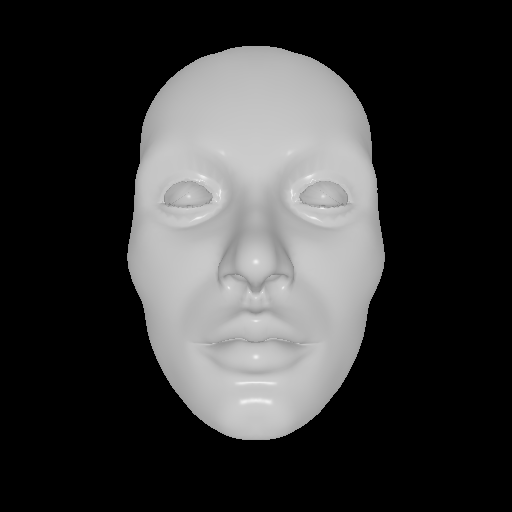

In [3]:
mesh  = flip_mesh(scale_mesh('./data/female_face.stl', offset=-0.20))
vertices = torch.tensor(mesh.vertices, device=device).float()
faces = torch.tensor(mesh.faces, device=device)[None]
normals = torch.tensor(mesh.vertex_normals, device=device)[None].float()
verts, ts = GeoAugment(vertices, config.geoaug_policy)
verts = verts[None]
t_points, t_normals = align(verts, normals)
renders =  R(t_points, faces, device)
print(renders.shape)
img = ToPILImage()(renders[0])
img

In [4]:
meshes = Meshes(verts=verts, faces=faces)
meshes

In [5]:
num_samples = 256**2
samples = sample_points_from_meshes(meshes, num_samples=num_samples)[0]
samples.shape

torch.Size([65536, 3])

In [5]:
stl_root = './data/stl_mesh/'
stl_files = os.listdir(stl_root)
stl_files.sort()
stl_files

['abe_white_inpatient.stl',
 'abigaile_ortiz_tomb_raider.stl',
 'ada_wong_resident_evil.stl',
 'administrator_evil_within.stl',
 'aidan_overkill_walking_dead.stl',
 'amelia_croft_tomb_raider.stl',
 'anakin_skywalker_battlefront_2.stl',
 'angela_civilian_detroit.stl',
 'annie_dead_rising.stl',
 'anya_gears_of_war.stl',
 'aphrodite_ascendant_one.stl',
 'aranea_highwind_final_fantasy.stl',
 'ares_ascendant_one.stl',
 'artemis_ascendant_one.stl',
 'athena_ascendant_one.stl',
 'badgirl_no_more_heroes.stl',
 'badman_no_more_heroes.stl',
 'becky_hidden_agenda.stl',
 'black_lightning_injustice_2.stl',
 'bridger_overkill_walking_dead.stl',
 'caligo_ulldor_final_fantasy.stl',
 'camelia_claustra_final_fantasy.stl',
 'cameron_burke_far_cry.stl',
 'carl_detroit.stl',
 'cassie_drake_uncharted.stl',
 'catherine_hidden_agenda.stl',
 'chloe_detroit.stl',
 'cid_sophiar_final_fantasy.stl',
 'cindy_aurum_final_fantasy.stl',
 'claire_resident_evil.stl',
 'clara_odea_assassins_creed.stl',
 'connor_detroit.s

In [3]:
def get_stl(file_path):
    mesh  = flip_mesh(scale_mesh(file_path, offset=-0.20))
    vertices = torch.tensor(mesh.vertices, device=device).float()
    faces = torch.tensor(mesh.faces, device=device)[None]
    normals = torch.tensor(mesh.vertex_normals, device=device)[None].float()
    verts, ts = GeoAugment(vertices, config.geoaug_policy)
    verts = verts[None]
    t_points, t_normals = align(verts, normals)
    return t_points, t_normals, faces
   

In [13]:
num_samples = 256**2

renders_root = './data/augmented/renders'
samples_root = './data/augmented/samples'

R = MeshFaceRenderer(config)
for i, stl_file in enumerate(stl_files):
    print(i, stl_file)
    file_path = os.path.join(stl_root, stl_file)
    print(file_path)
    mesh  = flip_mesh(scale_mesh(file_path, offset=-0.20))
    vertices = torch.tensor(mesh.vertices, device=device).float()
    faces = torch.tensor(mesh.faces, device=device)[None]
    normals = torch.tensor(mesh.vertex_normals, device=device)[None].float()
    
    for i in range(100):
        verts, ts = GeoAugment(vertices, config.geoaug_policy)
        verts = verts[None]
        vert, normals = align(verts, normals, rotate=False)    

        renders =  R(vert, faces, device)    
        img = ToPILImage()(renders[0])
        stl_name = stl_file.replace('.stl', '')
        render_dir =  os.path.join(renders_root, stl_name)
        if not os.path.exists(render_dir):
            os.makedirs(render_dir)
        infix = str(i).zfill(5)
        img.save(os.path.join(render_dir, stl_name + f'_{infix}.png'))

        samples_dir = os.path.join(samples_root, stl_name)
        if not os.path.exists(samples_dir):
            os.makedirs(samples_dir)

        meshes = Meshes(verts=verts.cpu(), faces=faces.cpu())
        samples = sample_points_from_meshes(meshes, num_samples=num_samples)[0]
        torch.save(samples, os.path.join(samples_dir, stl_name +  f'_{infix}.pth'))

0 abe_white_inpatient.stl
./data/stl_mesh/abe_white_inpatient.stl
1 abigaile_ortiz_tomb_raider.stl
./data/stl_mesh/abigaile_ortiz_tomb_raider.stl
2 ada_wong_resident_evil.stl
./data/stl_mesh/ada_wong_resident_evil.stl
3 administrator_evil_within.stl
./data/stl_mesh/administrator_evil_within.stl
4 aidan_overkill_walking_dead.stl
./data/stl_mesh/aidan_overkill_walking_dead.stl
5 amelia_croft_tomb_raider.stl
./data/stl_mesh/amelia_croft_tomb_raider.stl
6 anakin_skywalker_battlefront_2.stl
./data/stl_mesh/anakin_skywalker_battlefront_2.stl
7 angela_civilian_detroit.stl
./data/stl_mesh/angela_civilian_detroit.stl
8 annie_dead_rising.stl
./data/stl_mesh/annie_dead_rising.stl
9 anya_gears_of_war.stl
./data/stl_mesh/anya_gears_of_war.stl
10 aphrodite_ascendant_one.stl
./data/stl_mesh/aphrodite_ascendant_one.stl
11 aranea_highwind_final_fantasy.stl
./data/stl_mesh/aranea_highwind_final_fantasy.stl
12 ares_ascendant_one.stl
./data/stl_mesh/ares_ascendant_one.stl
13 artemis_ascendant_one.stl
./da

114 marta_martin_evil_within.stl
./data/stl_mesh/marta_martin_evil_within.stl
115 matt_two_souls.stl
./data/stl_mesh/matt_two_souls.stl
116 matt_until_dawn.stl
./data/stl_mesh/matt_until_dawn.stl
117 maya_overkill_walking_dead.stl
./data/stl_mesh/maya_overkill_walking_dead.stl
118 medusa_ascendant_one.stl
./data/stl_mesh/medusa_ascendant_one.stl
119 melanie_lemay_assassins_creed.stl
./data/stl_mesh/melanie_lemay_assassins_creed.stl
120 mike_until_dawn.stl
./data/stl_mesh/mike_until_dawn.stl
121 morrison_dmc.stl
./data/stl_mesh/morrison_dmc.stl
122 myra_hanson_evil_within.stl
./data/stl_mesh/myra_hanson_evil_within.stl
123 mysterious_figure_order_1886.stl
./data/stl_mesh/mysterious_figure_order_1886.stl
124 nero_dmc.stl
./data/stl_mesh/nero_dmc.stl
125 nick_rye_far_cry.stl
./data/stl_mesh/nick_rye_far_cry.stl
126 nico_dmc.stl
./data/stl_mesh/nico_dmc.stl
127 nike_ascendant_one.stl
./data/stl_mesh/nike_ascendant_one.stl
128 nikola_tesla_order_1886.stl
./data/stl_mesh/nikola_tesla_order_1